# 📦 Import Libraries

In [1]:
import joblib

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
from utils.data_acquisition import *
from utils.data_preprocessing import *

In [6]:
plot_size = (12, 6)

graph_colors = {
  "black": "#1F1E1F",
  "blue": "#03A9CE",
}

text_colors = {
  "title": "#262626",
  "subtitle": "#646464",
}

fig_path = "./figures/"

if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# 💾 Data Acquisition

In [7]:
DATA_PATH = "./data/"

GASOLINE_DATA_PATH_1 = DATA_PATH + "[Gasolina] Trajeto Casa-Escola-UFRN/"
GASOLINE_DATA_PATH_2 = DATA_PATH + "[Gasolina2023] Trajeto Casa-Escola-UFRN/"
ETHANOL_DATA_PATH = DATA_PATH + "[Etanol] Trajeto Casa-Escola-UFRN/"

GASOLINE_DATA_PATHS_1 = get_list_paths(GASOLINE_DATA_PATH_1)
GASOLINE_DATA_PATHS_2 = get_list_paths(GASOLINE_DATA_PATH_2)

GASOLINE_DATA_PATHS = GASOLINE_DATA_PATHS_1 + GASOLINE_DATA_PATHS_2

ETHANOL_DATA_PATHS = get_list_paths(ETHANOL_DATA_PATH)

SELECTED_COLUMNS = [
  "DeviceTime",
  "Latitude",
  "Longitude",
  "Speed(OBD)(km/h)",
  "AirFuelRatio(Commanded)(:1)",
  "MassAirFlowRate(g/s)",
  "Acceleration"
]

In [8]:
gasoline_01_12_2022 = pd.read_csv("./data/[Gasolina] Trajeto Casa-Escola-UFRN/trackLog-2022-Dec-01_06-43-57_qui.csv")
ethanol_13_02_2023 = pd.read_csv("./data/[Etanol] Trajeto Casa-Escola-UFRN/trackLog-2023-Feb-13_06-38-49_seg.csv")

In [9]:
LGBMRegressor_ethanol_afr = joblib.load("./models/LGBMRegressor_ethanol_afr.pkl")
LGBMRegressor_gasoline_afr = joblib.load("./models/LGBMRegressor_gasoline_afr.pkl")

In [10]:
XGBRegressor_ethanol_maf = joblib.load("./models/XGBRegressor_ethanol_maf.pkl")
XGBRegressor_gasoline_maf = joblib.load("./models/XGBRegressor_gasoline_maf.pkl")

# 🧩 Data Modelling

In [11]:
gasoline_01_12_2022 = remove_space_in_columns(gasoline_01_12_2022)
gasoline_01_12_2022["Acceleration"] = compute_acceleration(gasoline_01_12_2022)
gasoline_01_12_2022 = filter_columns(gasoline_01_12_2022, SELECTED_COLUMNS)

gasoline_01_12_2022.drop(columns=["DeviceTime"], inplace=True)

In [12]:
ethanol_13_02_2023 = remove_space_in_columns(ethanol_13_02_2023)
ethanol_13_02_2023["Acceleration"] = compute_acceleration(ethanol_13_02_2023)
ethanol_13_02_2023 = filter_columns(ethanol_13_02_2023, SELECTED_COLUMNS)

ethanol_13_02_2023.drop(columns=["DeviceTime"], inplace=True)

# 💨 Predict Emissions

## Gasoline

In [13]:
real_gasoline_emissions = []

for idx, row in gasoline_01_12_2022.iterrows():
    real_gasoline_emissions.append(
        compute_co2(
            row["AirFuelRatio(Commanded)(:1)"],
            row["MassAirFlowRate(g/s)"],
            fuel_type="gasoline"
        )
    )

In [14]:
pred_gasoline_emissions = []

for idx, row in gasoline_01_12_2022.iterrows():
    data = row[["Latitude", "Longitude", "Speed(OBD)(km/h)", "Acceleration"]].values
    
    pred_gasoline_emissions.append(
        compute_co2(
            LGBMRegressor_gasoline_afr.predict([data])[0],
            XGBRegressor_gasoline_maf.predict([data])[0],
            fuel_type="gasoline"
        )
    )

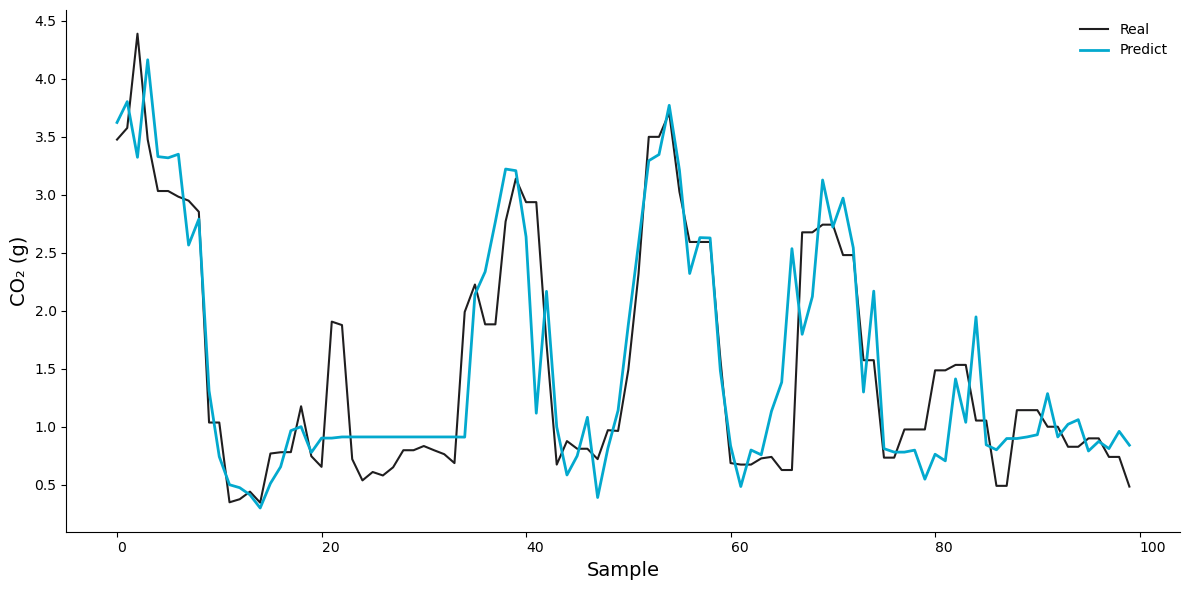

In [15]:
fig, ax = plt.subplots(figsize=plot_size)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel("CO₂ (g)", fontsize=14)
ax.set_xlabel("Sample", fontsize=14)

plt.xticks(rotation=0, ha="left")

ax.plot(list(range(100)), real_gasoline_emissions[-100:], label="Real", color=graph_colors["black"])
ax.plot(list(range(100)), pred_gasoline_emissions[-100:], label="Predict", color=graph_colors["blue"], linewidth=2)

# plt.text(0, 4.6, "CO₂ (g/s) - Predicted vs Real", fontsize=18, color=text_colors["title"], weight="bold")
# plt.text(0, 4.4, "Comparative between the last 100 samples of Gasoline data", fontsize=14, color=text_colors["subtitle"])

ax.legend(loc="upper right").set_frame_on(False)

plt.tight_layout()
plt.savefig(f"{fig_path}gasoline_co2.png")
plt.show()

In [16]:
mean_absolute_error(real_gasoline_emissions, pred_gasoline_emissions)

0.4153430839074334

In [17]:
mean_squared_error(real_gasoline_emissions, pred_gasoline_emissions)

0.3897019545407743

In [18]:
np.sqrt(mean_squared_error(real_gasoline_emissions, pred_gasoline_emissions))

0.6242611268858363

## Ethanol

In [19]:
real_ethanol_emissions = []

for idx, row in ethanol_13_02_2023.iterrows():
    real_ethanol_emissions.append(
        compute_co2(
            row["AirFuelRatio(Commanded)(:1)"],
            row["MassAirFlowRate(g/s)"],
            fuel_type="ethanol"
        )
    )

In [20]:
pred_ethanol_emissions = []

for idx, row in ethanol_13_02_2023.iterrows():
    data = row[["Latitude", "Longitude", "Speed(OBD)(km/h)", "Acceleration"]].values
    
    pred_ethanol_emissions.append(
        compute_co2(
            LGBMRegressor_ethanol_afr.predict([data])[0],
            XGBRegressor_ethanol_maf.predict([data])[0],
            fuel_type="ethanol"
        )
    )

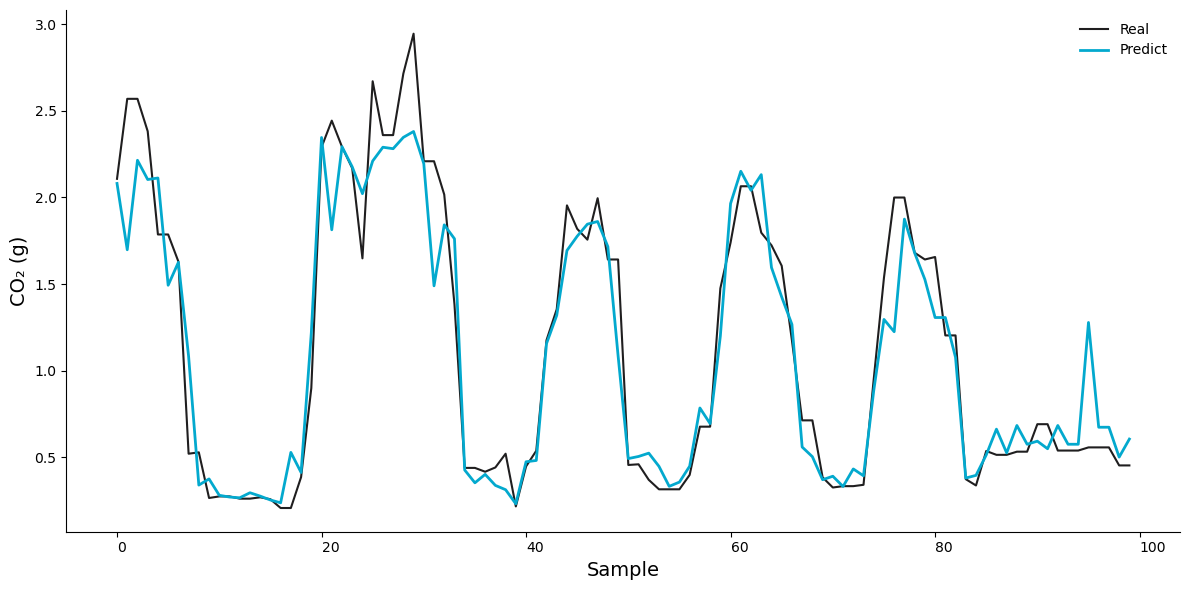

In [21]:
fig, ax = plt.subplots(figsize=plot_size)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel("CO₂ (g)", fontsize=14)
ax.set_xlabel("Sample", fontsize=14)

plt.xticks(rotation=0, ha="left")

ax.plot(list(range(100)), real_ethanol_emissions[-100:], label="Real", color=graph_colors["black"])
ax.plot(list(range(100)), pred_ethanol_emissions[-100:], label="Predict", color=graph_colors["blue"], linewidth=2)

# plt.text(0, 3.35, "CO₂ (g/s) - Predicted vs Real", fontsize=18, color=text_colors["title"], weight="bold")
# plt.text(0, 3.2, "Comparative between the last 100 samples of Ethanol data", fontsize=14, color=text_colors["subtitle"])

ax.legend(loc="upper right").set_frame_on(False)

plt.tight_layout()
plt.savefig(f"{fig_path}ethanol_co2.png")
plt.show()

In [22]:
mean_absolute_error(real_ethanol_emissions, pred_ethanol_emissions)

0.20491794673731073

In [23]:
mean_squared_error(real_ethanol_emissions, pred_ethanol_emissions)

0.10628761819933766

In [24]:
np.sqrt(mean_squared_error(real_ethanol_emissions, pred_ethanol_emissions))

0.3260178188371575